# Unary Operators Neural Network

This is a series of ANN examples that are trained on unary math operations.

For simple linear functions, small ANN can easily be trained to match the results without using ReLus.
The `abs` operation requires a ReLu, which makes sense.
The `flr` operations which maps `(-1,1)` to `{-1, 0}` is difficult to do with a SHL.
But `flr` works quite well with 2 layers.
Trig functions are fit well with one or two layers.

## Preliminaries

Import time, random, tensorflow and plotting libraries.

In [ ]:
from random import random, seed
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from numpy import matmul, array, fabs, set_printoptions, argmax, argmin, sum, linspace
from time import time

Set the random number seed, tf log level and enable inline plotting.

In [1]:
seed(9001)
tf.logging.set_verbosity(tf.logging.ERROR)
set_printoptions(suppress=True, precision=3)
%matplotlib inline

## `fr` function

`fr` formats floating point numbers into a standard format.

In [2]:
def fr(n):
    try:
        return ', '.join([fr(x) for x in n])
    except TypeError:
        return '{0:+.3f}'.format(n)

## `generator` function

`generator` returns a tuple where the `op` on the first two vectors results in the third vector.
It also returns the lambda expression.

If `op` is `''`, an the array of operations is return.

In [81]:
def generator(op='', n=1, show=5, epsilon=1e-6):

    operations = {
        'a': (lambda a: a),
        'neg': (lambda a: -a),
        'abs': (lambda a: math.fabs(a)),
        'exp': (lambda a: math.exp(a)),
        'log': (lambda a: math.log(math.fabs(a))),
        'sqrt': (lambda a: math.sqrt(math.fabs(a))),
        'sin': (lambda a: math.sin(math.pi * a)),
        'flr': (lambda a: math.floor(a))
    };
    
    if op == '':
        return [k for k in operations];
    
    if op in operations:
        uop = operations[op];
    else:
        raise NotImplementedError('Unknown Operator', op) 
    
    # generate a random number in (-1, 1)
    def rnd(nonzero=False):
        res = -1.0
        while res == -1.0 or (nonzero and res <= epsilon and res >= -epsilon):
            res = 2.0 * random() - 1.0
        return res

    # generate sample data
    av = []
    bv = []
    for i in range(n):
        a = rnd(nonzero=(op=='log'))
        b = uop(a)
        av.append(a)
        bv.append(b)
        if i < show:
            print(fr([a, b]))

    return av, bv, uop

## Sample output of `generator`

In [4]:
for op in generator():
    print('Operation: ' + op)
    generator(op=op, n=1)

Operation: a
-0.926, -0.926
Operation: neg
-0.494, +0.494
Operation: abs
+0.128, +0.128
Operation: exp
+0.139, +1.149
Operation: log
+0.212, -1.550
Operation: sqrt
+0.026, +0.162
Operation: sin
+0.425, +0.413
Operation: flr
+0.785, +0.000


## `train` the ANN

`train` runs the entire ANN optimization process.
Training and test data are simulated and
the DNN regressor is configured.
Then for each epoch: the training data are prepared for fitting;
the test data are evaluated;
predictions are made and training stops if they are close enough.

Graphical results are displayed showing the improvement in the loss function
and examples of the error results.

Each ANN layer is displayed as grayscale images of weights and biases.
hiddenlayer_0 will always have 2 rows
and the final logits layer will always have 1 column.

In [53]:
def train(op, hidden_units, epochs, samples, test_samples, steps,
          opt=tf.train.AdamOptimizer,
          epsilon=0.0, vrange=1.0, display=True):
    stime = time()
    losses = []
    layers = len(hidden_units)

    training = generator(op=op, n=samples, show=0, epsilon=epsilon)
    testing = generator(op=op, n=test_samples, show=0, epsilon=epsilon)
    
    estimator = tf.contrib.learn.DNNRegressor(
        feature_columns=[tf.contrib.layers.real_valued_column(k) for k in ['a']],
        optimizer=opt,
        hidden_units=hidden_units)

    def prepx(ds):
        return {
            'a': tf.constant(ds[0])
        }

    def prepy(ds):
        return tf.constant(ds[1])

    def prep(ds):
        return (prepx(ds), prepy(ds))
    
    for epoch in range(epochs):
        estimator.fit(input_fn=lambda: prep(training), steps=steps)
        res = estimator.evaluate(input_fn=lambda: prep(testing), steps=1)
        loss = res["loss"]
        losses.append(loss)
        
        prediction = list(estimator.predict(input_fn=lambda: prepx(testing)))
        expected = testing[1]
        errors = fabs(array(prediction) - array(expected))
        mine = argmin(errors)
        maxe = argmax(errors)
        ave = sum(errors) / test_samples
        if errors[maxe] < epsilon:
            break;

    etime = (time()-stime)/3600

    def aplot(axs, w, title):
        lmtx = len(w)
        lmty = len(w[0])
        intx = int(pow(10, math.floor(math.log10(lmtx)-.1)))
        inty = int(pow(10, math.floor(math.log10(lmty)-.1)))
        plt.xticks(linspace(0, lmtx, intx))
        plt.yticks(linspace(lmty, 0, inty))
        axs.set_title(title)
        im = axs.imshow(w, cmap="gray", vmin=-vrange, vmax=vrange)
        return im

    def wgtplot(axs, w, title):
        return aplot(axs, w, title + ' weights')

    def biasplot(axs, b, title):
        return aplot(axs, [b], title + ' biases')

    if display == True:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
        axs[0].plot(losses)
        axs[0].set_title(op + ' Losses: ' + fr(loss))
        axs[0].set_xlabel('epoch')
        axs[1].bar([i for i in range(test_samples)], sorted(errors, reverse=True))
        axs[1].set_title('Average Error:' + fr(ave))
        axs[1].set_xlabel('Test Sample')
        
        wgts = ['hiddenlayer_'+str(i) for i in range(layers)]
        wgts.append('logits')
        for i in range(len(wgts)):
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
            
            w = estimator.get_variable_value('dnn/'+wgts[i]+'/weights')
            wgtplot(axs[0], w, wgts[i])
            
            b = estimator.get_variable_value('dnn/'+wgts[i]+'/biases')
            im = biasplot(axs[1], b, wgts[i])
            fig.colorbar(im)
        plt.show()
        plt.close('all')
        
        print('Sample Calculation for: ' + op)
        testa = testing[0]
        testb = testing[1]
        testop = testing[2]
        lo = array([testa[mine]])
        hi = array([testa[maxe]])
        print('Inputs (lo, hi): {0:40s}{1:s}'.format(fr(lo), fr(hi)))
        print('Expected Output: {0:40s}{1:s}'.format(fr(testb[mine]), fr(testb[maxe])))
        for i in range(len(wgts)):
            w = estimator.get_variable_value('dnn/'+wgts[i]+'/weights')
            b = estimator.get_variable_value('dnn/'+wgts[i]+'/biases')
            print('')
            print('Layer ' + wgts[i])
            print(w)
            print(b)
            lo = lo.dot(w)
            hi = hi.dot(w)
            print('  Post Weights: {0:40s}{1:s}'.format(fr(lo), fr(hi)))
            lo = lo + b
            hi = hi + b
            print('  Post  Biases: {0:40s}{1:s}'.format(fr(lo), fr(hi)))
            if (wgts[i] != 'logits'):
                lo = array([max(lo[i], 0) for i in range(len(lo))])
                hi = array([max(hi[i], 0) for i in range(len(hi))])
                print('  Post    ReLu: {0:40s}{1:s}'.format(fr(lo), fr(hi)))

        print('')
        print('Elapse Time: {:.4f} hours'.format(etime))

    return {'testing': testing,
            'training': training,
            'ann': estimator,
            'losses': losses,
            'elapsed': etime
           }

##  `train` on simple problems

Consider the 1 node case where ReLu does not effect the calculation.
For any $x$ input:

$$
 \left[
  \left[ {\begin{array}{c}
   x
  \end{array} } \right]
  \left[ {\begin{array}{c}
   a \\
  \end{array} } \right]
  +
  \left[ {\begin{array}{c}
   b
  \end{array} } \right]
 \right]
 \left[ {\begin{array}{c}
   c \\
 \end{array} } \right]
 +
 \left[ {\begin{array}{c}
   d \\
 \end{array} } \right] = mx
$$

$$
  \left[ {\begin{array}{c}
   ax+b \\
  \end{array} } \right]
 \left[ {\begin{array}{c}
   c \\
 \end{array} } \right]
 +
 \left[ {\begin{array}{c}
   d \\
 \end{array} } \right] = mx
$$

$$
 \begin{array}{ccc}
  cax+cb & +\ d & = mx \\
  acx & +\ (cb+d) & = mx \\
   ac = m & cb+d = 0 & \\
   a = m/c & d = -cb & \\
  \end{array}
$$

Consider the 2 node case where ReLu does not effect the calculation.
For any $x$ input:

$$
 \left[
  \left[ {\begin{array}{c}
   x
  \end{array} } \right]
  \left[ {\begin{array}{cc}
   a & b \\
  \end{array} } \right]
  +
  \left[ {\begin{array}{cc}
   c & d
  \end{array} } \right]
 \right]
 \left[ {\begin{array}{c}
   e \\
   f \\
 \end{array} } \right]
 +
 \left[ {\begin{array}{c}
   i \\
 \end{array} } \right] = mx
$$

$$
  \left[ {\begin{array}{cc}
   ax+c & bx+d \\
  \end{array} } \right]
 \left[ {\begin{array}{c}
   e \\
   f \\
 \end{array} } \right]
 +
 \left[ {\begin{array}{c}
   i \\
 \end{array} } \right] = mx
$$

$$
 \begin{array}{ccc}
  eax+ec +\ fbx+fd & +\ i & = mx \\
  (ea+fb)x & +\ (ec+fd+i) & = mx \\
   (ea + fb) = m & ec+fd+i = 0 & \\
   a = (m-fb)/e & i = -ec-fd & \\
  \end{array}
$$


## Single node test

For any `m` there is a simple linear solution that doesn't involve ReLus.

This next test tries a variety of step values in the regression.
Note that the error (and loss) improve with an increase in the steps,
with no significant change in the runtime.
The tensorflow documentation states that a training step is one gradient update.
With a larger number of steps then a larger number of gradients are updated.
In this configuration `batch_size` is the number of data points.
So 1 step means each data point is only consider one time in the epoch.
With 100 steps, each data point is consider 100 times.

With `m = 1` one run picked `b = a` and `c = 1/a` and `d = -1` which didn't involve ReLu.
`c = 1/a` comes from `a = m/c` and `d = (-1/a)a = -1`. But choosing `b = a` is not necessary.

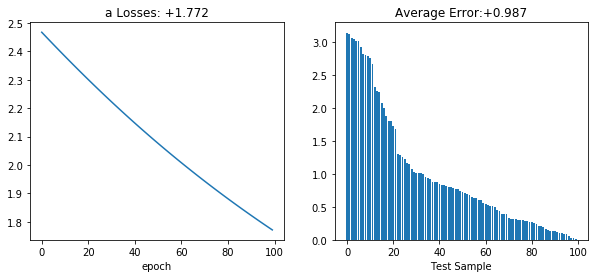

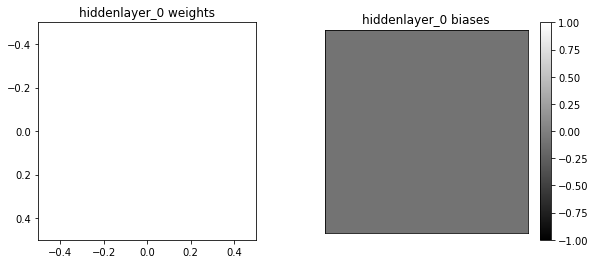

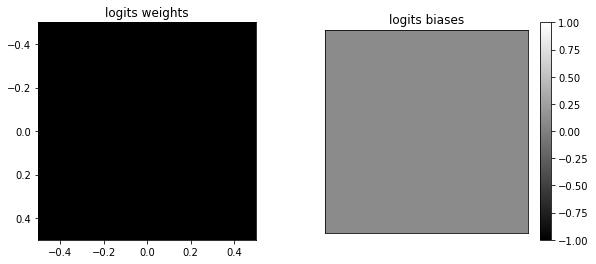

Sample Calculation for: a
Inputs (lo, hi): +0.074                                  +0.984
Expected Output: +0.074                                  +0.984

Layer hiddenlayer_0
[[1.498]]
[-0.095]
  Post Weights: +0.111                                  +1.474
  Post  Biases: +0.016                                  +1.379
  Post    ReLu: +0.016                                  +1.379

Layer logits
[[-1.631]]
[0.093]
  Post Weights: -0.026                                  -2.249
  Post  Biases: +0.067                                  -2.155

Elapse Time: 0.0822 hours


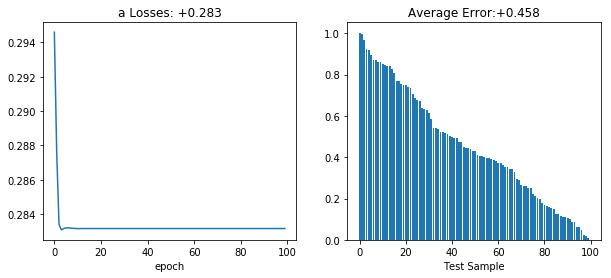

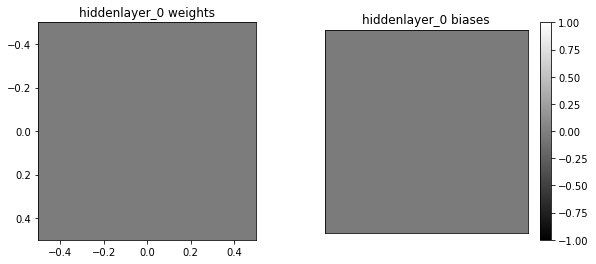

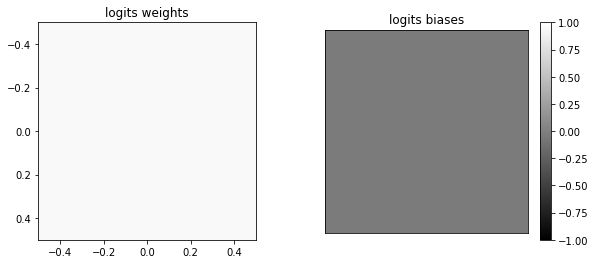

Sample Calculation for: a
Inputs (lo, hi): -0.025                                  +0.971
Expected Output: -0.025                                  +0.971

Layer hiddenlayer_0
[[-0.026]]
[-0.039]
  Post Weights: +0.001                                  -0.025
  Post  Biases: -0.038                                  -0.064
  Post    ReLu: +0.000                                  +0.000

Layer logits
[[0.95]]
[-0.032]
  Post Weights: +0.000                                  +0.000
  Post  Biases: -0.032                                  -0.032

Elapse Time: 0.1269 hours


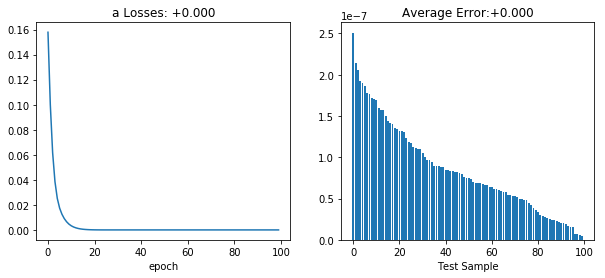

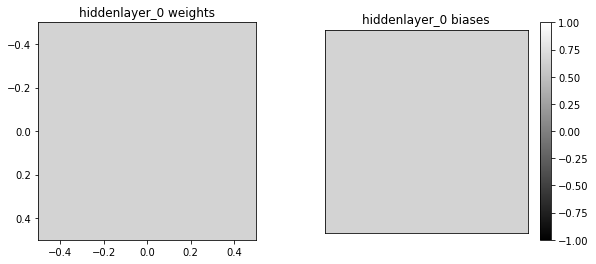

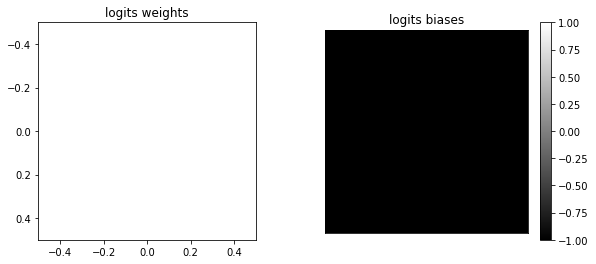

Sample Calculation for: a
Inputs (lo, hi): +0.899                                  +0.750
Expected Output: +0.899                                  +0.750

Layer hiddenlayer_0
[[0.656]]
[0.655]
  Post Weights: +0.590                                  +0.492
  Post  Biases: +1.244                                  +1.146
  Post    ReLu: +1.244                                  +1.146

Layer logits
[[1.525]]
[-0.998]
  Post Weights: +1.897                                  +1.748
  Post  Biases: +0.899                                  +0.750

Elapse Time: 0.1072 hours


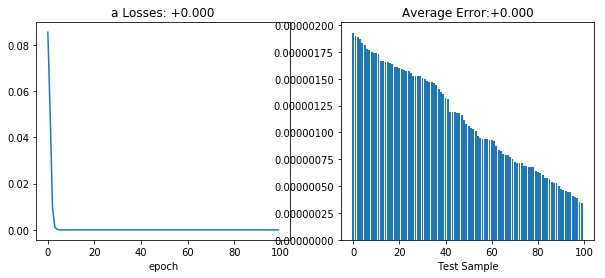

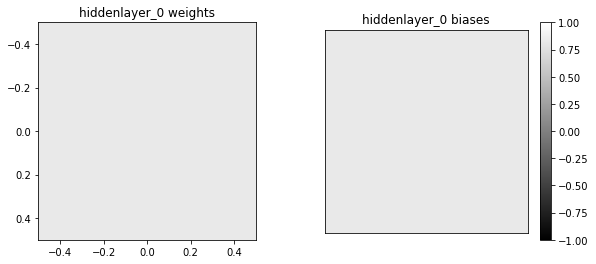

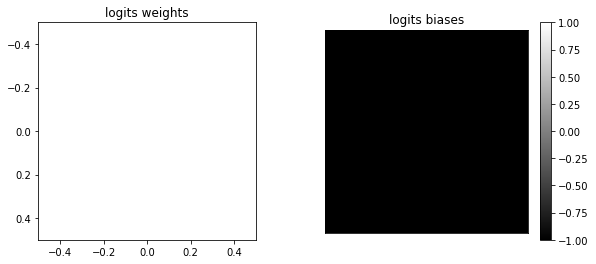

Sample Calculation for: a
Inputs (lo, hi): -0.996                                  +0.930
Expected Output: -0.996                                  +0.930

Layer hiddenlayer_0
[[0.825]]
[0.823]
  Post Weights: -0.822                                  +0.767
  Post  Biases: +0.001                                  +1.591
  Post    ReLu: +0.001                                  +1.591

Layer logits
[[1.212]]
[-0.998]
  Post Weights: +0.002                                  +1.928
  Post  Biases: -0.996                                  +0.930

Elapse Time: 0.1217 hours


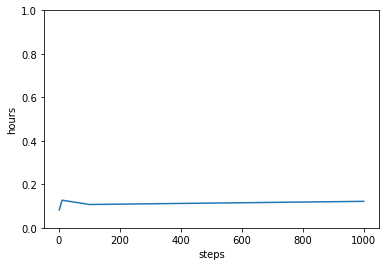

In [55]:
def teststeps(steps = [1, 10, 100, 1000]):
    timing = []
    for step in steps:
        op = train('a', [1], 100, 900, 100, step, epsilon=0.0)
        timing.append(op['elapsed'])
    axs = plt.gca()
    axs.set_xlabel('steps')
    axs.set_ylabel('hours')
    axs.set_ylim(bottom=0)    
    plt.plot(steps, timing)
    plt.show()
    plt.close('all')
teststeps()

## Two node test

For `m = 1`, one run picked `.468, .624, .451, .599, .575, 1.172, -0.962`.
So, `.575*.468+.1.172*.624 = .269+.731 = 1`.
That is `ae = 1 - fb`.
And `.575*.451+1.172*.599-.962 = .259+.702-.962 = 0`

Note that the `i` picked is the minimum of all the sample data.

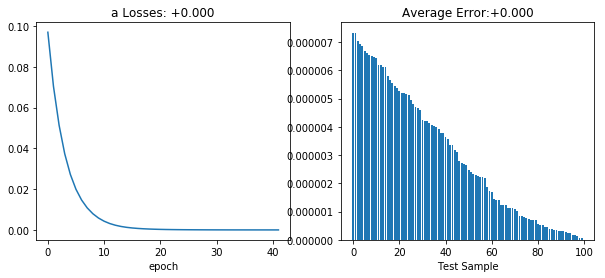

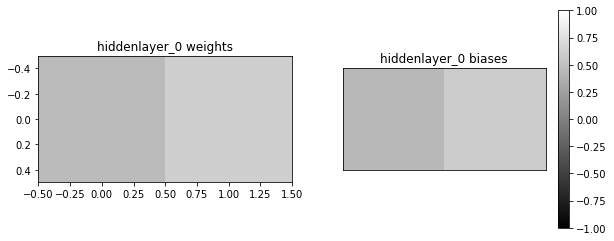

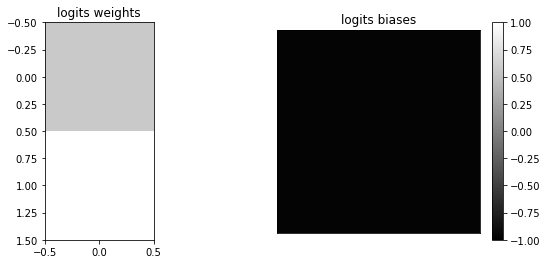

Sample Calculation for: a
Inputs (lo, hi): +0.733                                  -0.960
Expected Output: +0.733                                  -0.960

Layer hiddenlayer_0
[[0.468 0.624]]
[0.451 0.599]
  Post Weights: +0.344, +0.457                          -0.450, -0.599
  Post  Biases: +0.795, +1.057                          +0.001, +0.000
  Post    ReLu: +0.795, +1.057                          +0.001, +0.000

Layer logits
[[0.575]
 [1.172]]
[-0.962]
  Post Weights: +1.695                                  +0.001
  Post  Biases: +0.733                                  -0.960

Elapse Time: 0.0467 hours


In [56]:
op = train('a', [2], 100, 900, 100, 100, epsilon=0.0005)

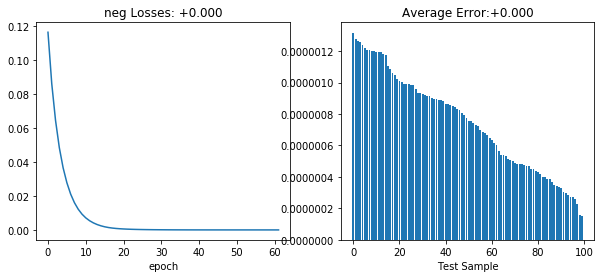

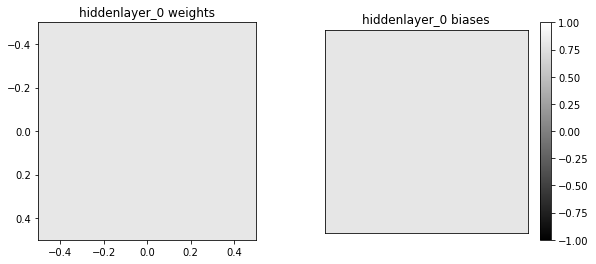

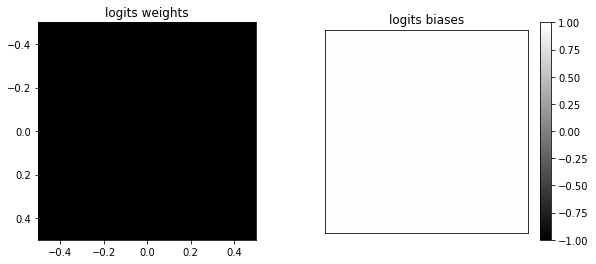

Sample Calculation for: neg
Inputs (lo, hi): +0.906                                  -0.947
Expected Output: -0.906                                  +0.947

Layer hiddenlayer_0
[[0.81]]
[0.802]
  Post Weights: +0.734                                  -0.767
  Post  Biases: +1.536                                  +0.034
  Post    ReLu: +1.536                                  +0.034

Layer logits
[[-1.234]]
[0.99]
  Post Weights: -1.896                                  -0.043
  Post  Biases: -0.906                                  +0.947

Elapse Time: 0.0678 hours


In [57]:
op = train('neg', [1], 100, 900, 100, 100, epsilon=0.0005)

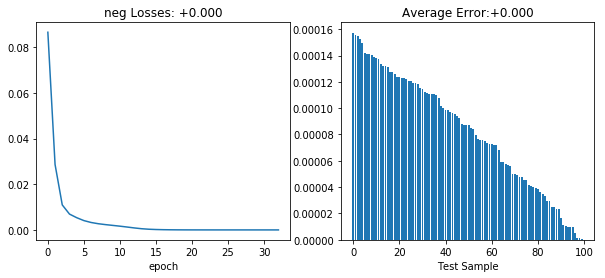

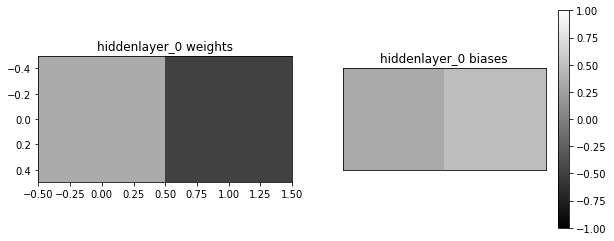

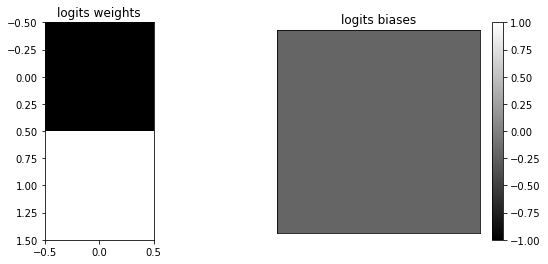

Sample Calculation for: neg
Inputs (lo, hi): -0.026                                  +0.973
Expected Output: +0.026                                  -0.973

Layer hiddenlayer_0
[[ 0.34  -0.484]]
[0.33  0.477]
  Post Weights: -0.009, +0.013                          +0.330, -0.470
  Post  Biases: +0.321, +0.490                          +0.661, +0.007
  Post    ReLu: +0.321, +0.490                          +0.661, +0.007

Layer logits
[[-1.177]
 [ 1.242]]
[-0.204]
  Post Weights: +0.230                                  -0.769
  Post  Biases: +0.026                                  -0.973

Elapse Time: 0.0359 hours


In [58]:
op = train('neg', [2], 100, 900, 100, 100, epsilon=0.0005)

abs sometimes doesn't work with 2 nodes.

Each abs solution that works involves a ReLu.

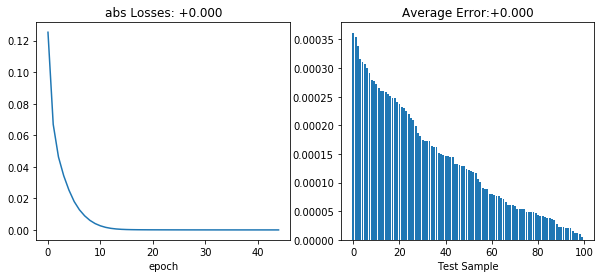

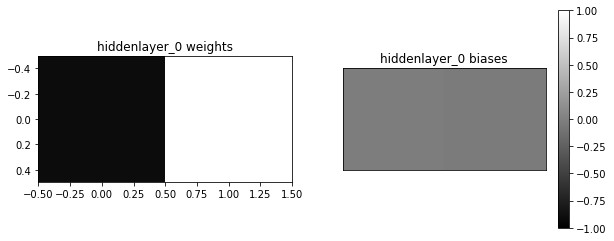

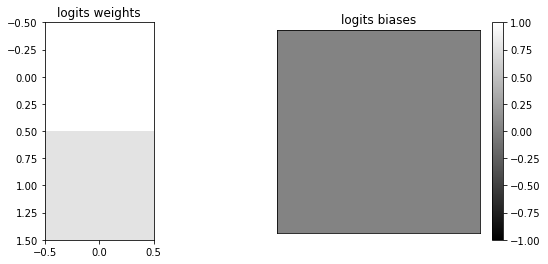

Sample Calculation for: abs
Inputs (lo, hi): -0.661                                  +0.029
Expected Output: +0.661                                  +0.029

Layer hiddenlayer_0
[[-0.905  1.286]]
[-0.023 -0.033]
  Post Weights: +0.599, -0.850                          -0.027, +0.038
  Post  Biases: +0.575, -0.884                          -0.050, +0.005
  Post    ReLu: +0.575, +0.000                          +0.000, +0.005

Layer logits
[[1.105]
 [0.778]]
[0.025]
  Post Weights: +0.636                                  +0.004
  Post  Biases: +0.661                                  +0.029

Elapse Time: 0.0465 hours


In [59]:
op = train('abs', [2], 100, 900, 100, 100, epsilon=0.0005)

Sometimes abs doesn't work with 3 nodes.

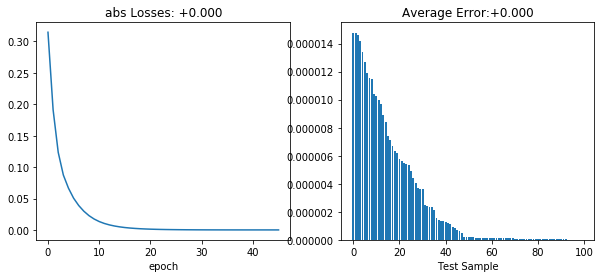

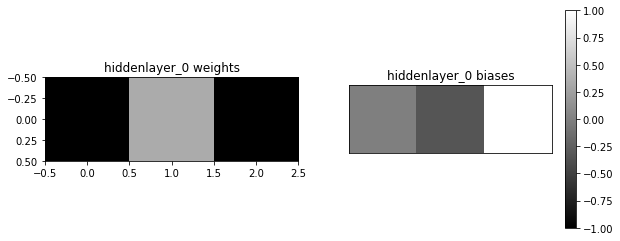

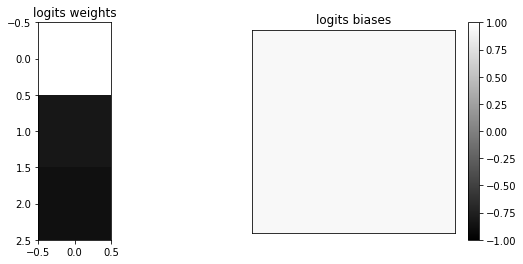

Sample Calculation for: abs
Inputs (lo, hi): -0.712                                  +0.029
Expected Output: +0.712                                  +0.029

Layer hiddenlayer_0
[[-1.38   0.338 -1.153]]
[-0.    -0.332  1.087]
  Post Weights: +0.983, -0.241, +0.821                  -0.040, +0.010, -0.033
  Post  Biases: +0.983, -0.573, +1.908                  -0.040, -0.323, +1.054
  Post    ReLu: +0.983, +0.000, +1.908                  +0.000, +0.000, +1.054

Layer logits
[[ 1.45 ]
 [-0.813]
 [-0.868]]
[0.943]
  Post Weights: -0.231                                  -0.914
  Post  Biases: +0.712                                  +0.029

Elapse Time: 0.0454 hours


In [60]:
op = train('abs', [3], 100, 900, 100, 100, epsilon=0.0005)

Sometimes abs doesn't work with 4 nodes.

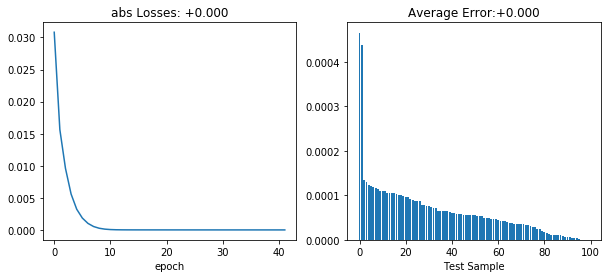

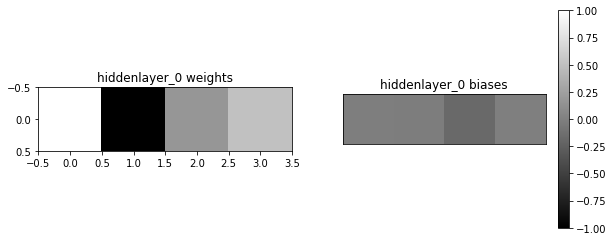

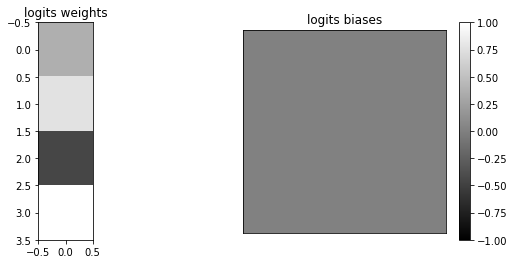

Sample Calculation for: abs
Inputs (lo, hi): +0.647                                  +0.014
Expected Output: +0.647                                  +0.014

Layer hiddenlayer_0
[[ 1.001 -1.306  0.178  0.509]]
[-0.015 -0.016 -0.176 -0.005]
  Post Weights: +0.648, -0.845, +0.115, +0.329          +0.014, -0.018, +0.002, +0.007
  Post  Biases: +0.632, -0.861, -0.061, +0.324          -0.002, -0.034, -0.174, +0.001
  Post    ReLu: +0.632, +0.000, +0.000, +0.324          +0.000, +0.000, +0.000, +0.001

Layer logits
[[ 0.373]
 [ 0.766]
 [-0.446]
 [ 1.232]]
[0.012]
  Post Weights: +0.635                                  +0.002
  Post  Biases: +0.647                                  +0.014

Elapse Time: 0.0479 hours


In [61]:
op = train('abs', [4], 100, 900, 100, 100, epsilon=0.0005)

abs seems to always work with 5 nodes.

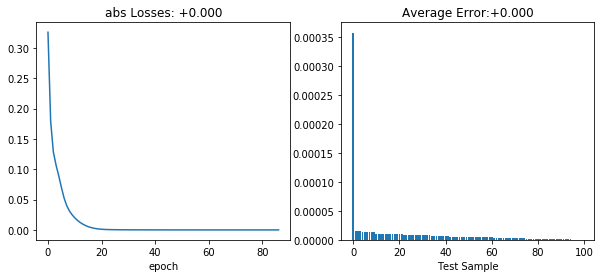

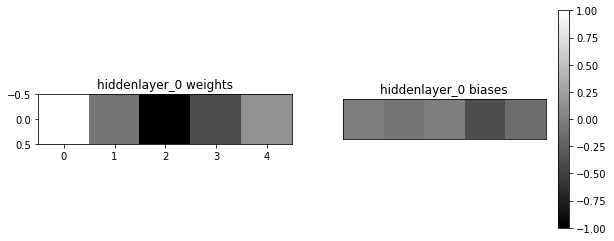

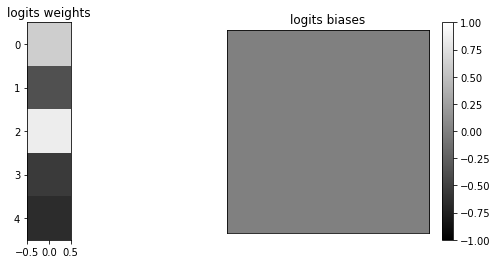

Sample Calculation for: abs
Inputs (lo, hi): -0.578                                  +0.007
Expected Output: +0.578                                  +0.007

Layer hiddenlayer_0
[[ 1.636 -0.075 -1.167 -0.387  0.145]]
[-0.012 -0.078 -0.009 -0.385 -0.145]
  Post Weights: -0.946, +0.043, +0.674, +0.224, -0.084  +0.011, -0.001, -0.008, -0.003, +0.001
  Post  Biases: -0.958, -0.034, +0.666, -0.161, -0.229  -0.001, -0.078, -0.017, -0.387, -0.144
  Post    ReLu: +0.000, +0.000, +0.666, +0.000, +0.000  +0.000, +0.000, +0.000, +0.000, +0.000

Layer logits
[[ 0.611]
 [-0.371]
 [ 0.857]
 [-0.539]
 [-0.645]]
[0.007]
  Post Weights: +0.571                                  +0.000
  Post  Biases: +0.578                                  +0.007

Elapse Time: 0.0983 hours


In [62]:
op = train('abs', [5], 100, 900, 100, 100, epsilon=0.0005)

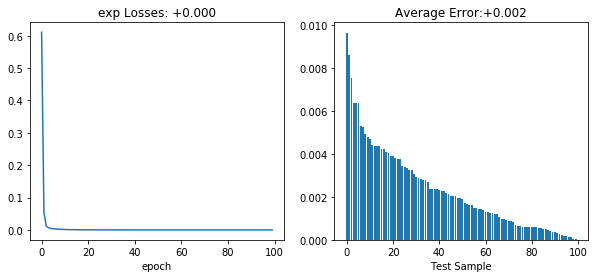

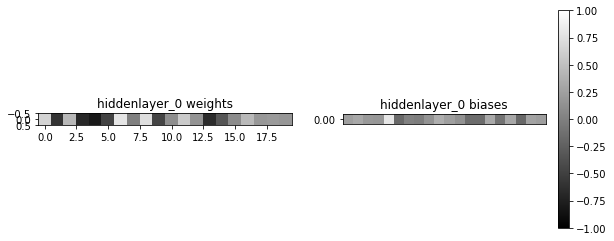

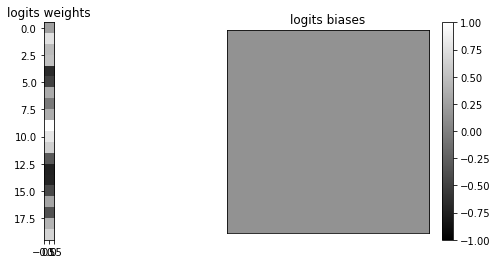

Sample Calculation for: exp
Inputs (lo, hi): -0.498                                  +0.529
Expected Output: +0.607                                  +1.697

Layer hiddenlayer_0
[[ 0.656 -0.59   0.44  -0.674 -0.803 -0.474  0.794  0.003  0.738 -0.462
   0.112  0.581  0.153 -0.642 -0.323  0.098  0.448  0.182  0.207  0.176]]
[ 0.248  0.313  0.196  0.18   0.802 -0.187  0.011 -0.019  0.162  0.362
  0.244  0.146 -0.153 -0.151  0.323 -0.098  0.311 -0.182  0.284  0.241]
  Post Weights: -0.327, +0.294, -0.219, +0.336, +0.400, +0.236, -0.396, -0.001, -0.368, +0.231, -0.056, -0.290, -0.076, +0.320, +0.161, -0.049, -0.223, -0.091, -0.103, -0.088+0.347, -0.312, +0.233, -0.356, -0.425, -0.251, +0.420, +0.001, +0.390, -0.245, +0.059, +0.307, +0.081, -0.339, -0.171, +0.052, +0.237, +0.096, +0.110, +0.093
  Post  Biases: -0.080, +0.607, -0.024, +0.516, +1.202, +0.050, -0.385, -0.021, -0.206, +0.593, +0.188, -0.144, -0.229, +0.169, +0.484, -0.146, +0.088, -0.273, +0.181, +0.153+0.595, +0.001, +0.428, -0.

In [67]:
op = train('exp', [20], 100, 900, 100, 100, epsilon=0.0005)

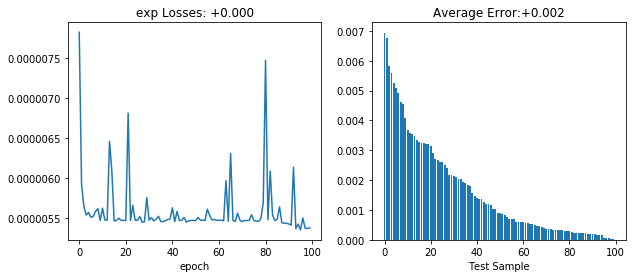

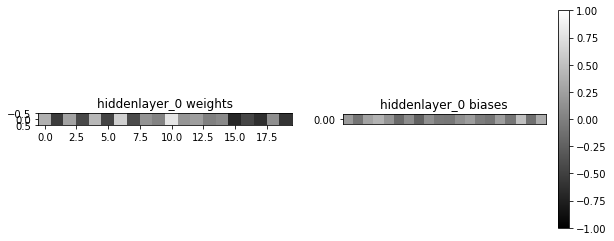

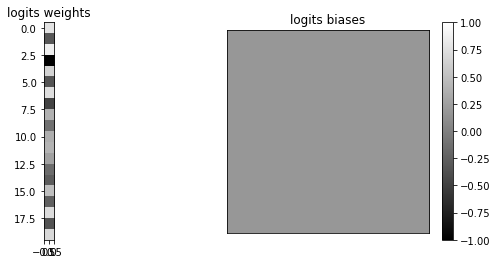

Sample Calculation for: exp
Inputs (lo, hi): -0.521                                  +0.346
Expected Output: +0.594                                  +1.413

Layer hiddenlayer_0
[[ 0.377 -0.529  0.284 -0.414  0.445 -0.464  0.632 -0.41   0.149  0.036
   0.79   0.169  0.237  0.002  0.077 -0.696 -0.449 -0.627  0.122 -0.591]]
[ 0.214 -0.09   0.284  0.41   0.165 -0.174  0.105 -0.235  0.126 -0.045
 -0.07   0.12   0.232 -0.019 -0.079  0.24  -0.077  0.501 -0.12   0.344]
  Post Weights: -0.196, +0.275, -0.148, +0.216, -0.232, +0.242, -0.329, +0.214, -0.078, -0.019, -0.411, -0.088, -0.124, -0.001, -0.040, +0.363, +0.234, +0.326, -0.063, +0.308+0.130, -0.183, +0.098, -0.143, +0.154, -0.161, +0.219, -0.142, +0.052, +0.013, +0.273, +0.059, +0.082, +0.001, +0.027, -0.241, -0.155, -0.217, +0.042, -0.204
  Post  Biases: +0.018, +0.185, +0.136, +0.625, -0.066, +0.068, -0.224, -0.022, +0.049, -0.064, -0.481, +0.032, +0.108, -0.020, -0.120, +0.602, +0.157, +0.827, -0.184, +0.652+0.344, -0.273, +0.382, +0.

In [68]:
op = train('exp', [20], 100, 900, 100, 10000, epsilon=0.0005)

## Floor results

Output is either -1 or 0.

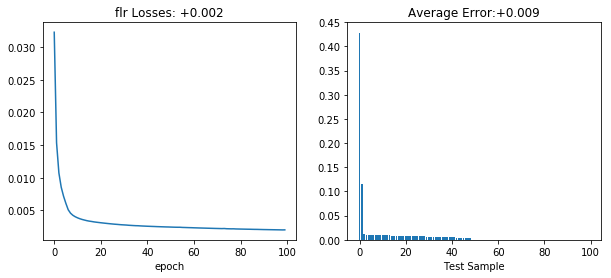

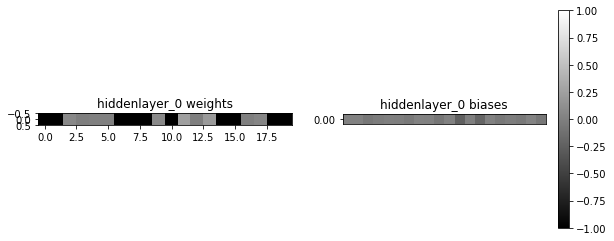

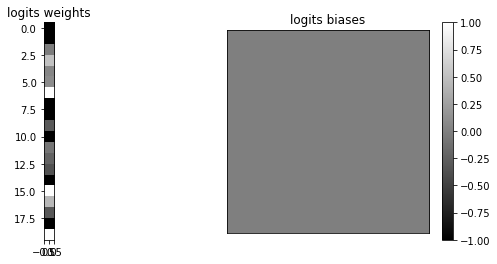

Sample Calculation for: flr
Inputs (lo, hi): +0.770                                  -0.005
Expected Output: +0.000                                  -1.000

Layer hiddenlayer_0
[[-2.776 -2.594  0.065 -0.013  0.005  0.004 -3.625 -3.234 -2.629  0.072
  -2.567  0.243 -0.005  0.206 -2.603 -4.481 -0.007  0.047 -4.295 -4.885]]
[ 0.014  0.013 -0.065 -0.025 -0.006 -0.012 -0.048  0.017  0.014 -0.074
  0.013 -0.242 -0.006 -0.206  0.014 -0.061 -0.022 -0.052  0.027 -0.068]
  Post Weights: -2.139, -1.998, +0.050, -0.010, +0.004, +0.003, -2.793, -2.492, -2.026, +0.056, -1.978, +0.187, -0.004, +0.159, -2.006, -3.453, -0.005, +0.036, -3.309, -3.764+0.015, +0.014, -0.000, +0.000, -0.000, -0.000, +0.020, +0.018, +0.014, -0.000, +0.014, -0.001, +0.000, -0.001, +0.014, +0.024, +0.000, -0.000, +0.023, +0.026
  Post  Biases: -2.124, -1.985, -0.015, -0.035, -0.002, -0.009, -2.841, -2.475, -2.012, -0.018, -1.964, -0.055, -0.010, -0.047, -1.992, -3.514, -0.027, -0.016, -3.283, -3.831+0.029, +0.028, -0.065, -0.

In [76]:
op = train('flr', [20], 100, 900, 100, 1000, epsilon=0.0005)

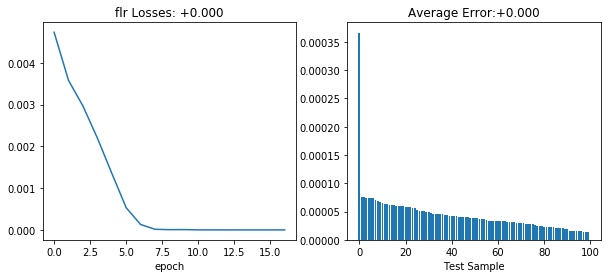

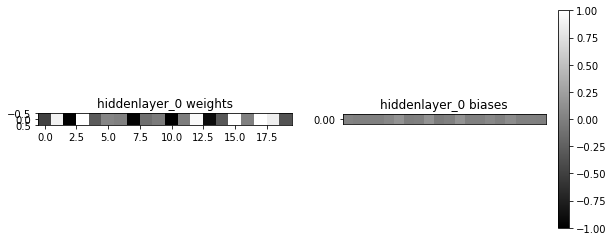

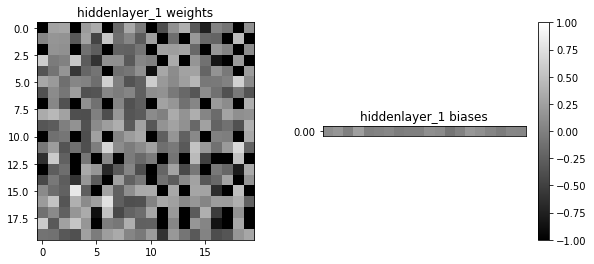

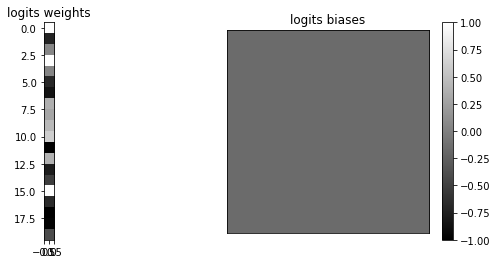

Sample Calculation for: flr
Inputs (lo, hi): +0.078                                  +0.004
Expected Output: +0.000                                  +0.000

Layer hiddenlayer_0
[[-0.49   0.89  -2.242  1.328 -0.288  0.047  0.001 -0.964 -0.132 -0.033
  -1.714 -0.021  0.947 -0.906 -0.306  1.72   0.007  1.539  0.863 -0.345]]
[ 0.039  0.001  0.006  0.002  0.062  0.156 -0.015  0.002  0.149 -0.034
  0.004  0.16   0.001  0.002  0.066  0.002  0.099  0.002  0.001 -0.   ]
  Post Weights: -0.038, +0.070, -0.175, +0.104, -0.023, +0.004, +0.000, -0.075, -0.010, -0.003, -0.134, -0.002, +0.074, -0.071, -0.024, +0.135, +0.001, +0.120, +0.067, -0.027-0.002, +0.003, -0.009, +0.005, -0.001, +0.000, +0.000, -0.004, -0.001, -0.000, -0.007, -0.000, +0.004, -0.003, -0.001, +0.007, +0.000, +0.006, +0.003, -0.001
  Post  Biases: +0.000, +0.071, -0.170, +0.106, +0.040, +0.160, -0.015, -0.073, +0.139, -0.037, -0.130, +0.159, +0.075, -0.069, +0.042, +0.137, +0.100, +0.122, +0.069, -0.027+0.037, +0.004, -0.003, +0.

In [75]:
op = train('flr', [20, 20], 100, 900, 100, 1000, epsilon=0.0005)

## Sin Results

Recall that `sin(x)` is approximately `x` for small angles.

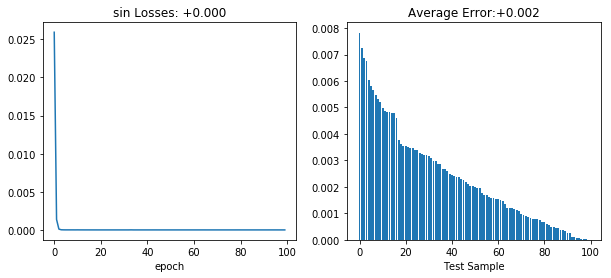

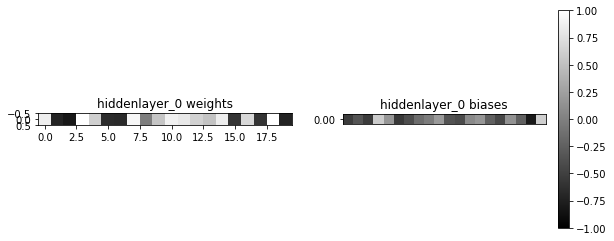

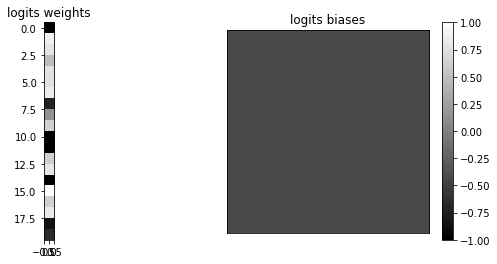

Sample Calculation for: sin
Inputs (lo, hi): -0.353                                  +0.617
Expected Output: -0.895                                  +0.933

Layer hiddenlayer_0
[[ 0.865 -0.704 -0.81   1.095  0.622 -0.651 -0.667  0.924 -0.012  0.543
   0.886  0.819  0.637  0.531  0.853 -0.589  0.689 -0.593  1.078 -0.726]]
[-0.53  -0.337 -0.534  0.589  0.173 -0.559 -0.395 -0.144 -0.025  0.205
 -0.348 -0.409  0.083  0.179 -0.244 -0.441  0.147 -0.25  -0.797  0.623]
  Post Weights: -0.305, +0.248, +0.286, -0.386, -0.219, +0.230, +0.235, -0.326, +0.004, -0.191, -0.312, -0.289, -0.224, -0.187, -0.301, +0.208, -0.243, +0.209, -0.380, +0.256+0.534, -0.434, -0.500, +0.676, +0.384, -0.402, -0.411, +0.570, -0.007, +0.335, +0.547, +0.506, +0.393, +0.328, +0.526, -0.364, +0.425, -0.366, +0.665, -0.448
  Post  Biases: -0.835, -0.089, -0.249, +0.203, -0.046, -0.330, -0.160, -0.470, -0.021, +0.013, -0.661, -0.698, -0.142, -0.009, -0.544, -0.233, -0.096, -0.041, -1.177, +0.879+0.004, -0.772, -1.034, +1.

In [82]:
op = train('sin', [20], 100, 900, 100, 1000, epsilon=0.0005)

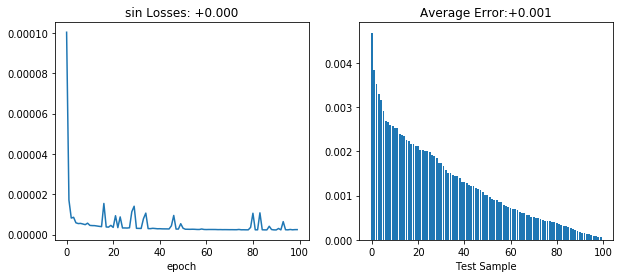

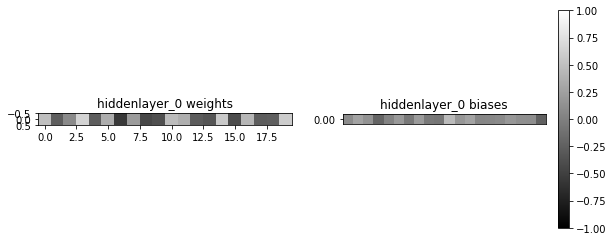

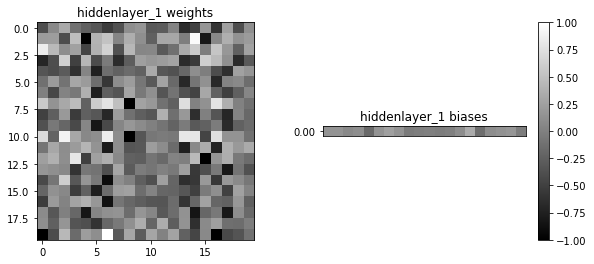

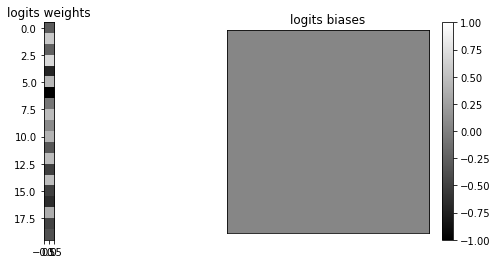

Sample Calculation for: sin
Inputs (lo, hi): +0.467                                  -0.726
Expected Output: +0.995                                  -0.758

Layer hiddenlayer_0
[[ 0.499 -0.26   0.086  0.663 -0.27   0.354 -0.559  0.218 -0.438 -0.383
   0.469  0.36  -0.278 -0.333  0.573 -0.405  0.424 -0.27  -0.252  0.6  ]]
[ 0.094  0.288  0.155 -0.217  0.024  0.2   -0.059  0.218 -0.046 -0.073
  0.469  0.18   0.277  0.047  0.06   0.08   0.183  0.124  0.11  -0.235]
  Post Weights: +0.233, -0.121, +0.040, +0.310, -0.126, +0.165, -0.261, +0.102, -0.205, -0.179, +0.219, +0.168, -0.130, -0.156, +0.267, -0.189, +0.198, -0.126, -0.118, +0.280-0.362, +0.189, -0.062, -0.482, +0.196, -0.257, +0.406, -0.158, +0.318, +0.278, -0.341, -0.261, +0.202, +0.242, -0.416, +0.294, -0.308, +0.196, +0.183, -0.436
  Post  Biases: +0.327, +0.167, +0.195, +0.093, -0.102, +0.366, -0.320, +0.320, -0.251, -0.251, +0.688, +0.348, +0.147, -0.109, +0.328, -0.109, +0.381, -0.002, -0.008, +0.045-0.268, +0.477, +0.093, -0.

In [83]:
op = train('sin', [20, 20], 100, 900, 100, 1000, epsilon=0.0005)